#### Imports and Packages

In [156]:
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import cohen_kappa_score
from sklearn.linear_model import LogisticRegression
import optuna
from optuna.samplers import TPESampler
import lightgbm as lgb
import xgboost as xgb

import warnings
warnings.filterwarnings("ignore", category=UserWarning)

#### Data pre-processing and functions

In [157]:
class WineDataProcessor:
    
    def __init__(self, train_df, test_df):
        self.train_df = train_df
        self.test_df = test_df

    def add_columns(self, df):
        df['total_acid'] = df['fixed acidity'] + df['volatile acidity'] + df['citric acid']
        df['acid/density'] = df['total_acid']  / df['density']
        df['alcohol_density'] = df['alcohol']  * df['density']
        df['sulphate/density'] = df['sulphates']  / df['density']
        df['sulphates/acid'] = df['sulphates'] / df['volatile acidity']
        df['sulphates/chlorides'] = df['sulphates'] / df['chlorides']
        df['sulphates*alcohol'] = df['sulphates'] / df['alcohol']
        return df
    
    def process_data(self):
        self.train_df = self.add_columns(self.train_df).assign(
            pH_round1 = self.train_df['pH'].round(1),
            log1p_residual_sugar = np.log1p(self.train_df['residual sugar']),
            citric_acid_per_alcohol = np.where(self.train_df['alcohol'] == 0, 0, self.train_df['citric acid'] / self.train_df['alcohol']),
        ).assign(
            citric_acid_type = lambda df: df['citric acid'].apply(lambda x: 0 if x == 0 else (1 if x == 0.49 else 2)),
            alcohol_mean_groupby_pH = lambda df: df.groupby('pH_round1')['alcohol'].transform('mean')
        )

        self.test_df = self.add_columns(self.test_df).assign(
            pH_round1 = self.test_df['pH'].round(1),
            log1p_residual_sugar = np.log1p(self.test_df['residual sugar']),
            citric_acid_per_alcohol = np.where(self.test_df['alcohol'] == 0, 0, self.test_df['citric acid'] / self.test_df['alcohol']),
        ).assign(
            citric_acid_type = lambda df: df['citric acid'].apply(lambda x: 0 if x == 0 else (1 if x == 0.49 else 2)),
            alcohol_mean_groupby_pH = lambda df: df.groupby('pH_round1')['alcohol'].transform('mean')
        )

        return self.train_df, self.test_df
    
class OptunaRounder: # credit to : kotrying

    def __init__(self, y_true, y_pred):
        self.y_true = y_true
        self.y_pred = y_pred
        self.labels = np.unique(y_true)

    def __call__(self, trial):
        thresholds = []
        for i in range(len(self.labels) - 1):
            low = max(thresholds) if i > 0 else min(self.labels)
            high = max(self.labels)
            t = trial.suggest_float(f't{i}', low, high)
            thresholds.append(t)
        try:
            opt_y_pred = self.adjust(self.y_pred, thresholds)
        except: return 0
        return cohen_kappa_score(self.y_true, opt_y_pred, weights='quadratic')

    def adjust(self, y_pred, thresholds):
        opt_y_pred = pd.cut(y_pred,
                            [-np.inf] + thresholds + [np.inf],
                            labels=self.labels)
        return opt_y_pred

def read_csv(path):
    """
    Reads a CSV file from the given path and returns the Pandas dataframe.
    """
    return pd.read_csv(path)

def train_lgbm_model(X_train, y_train, X_val, y_val, lgb_params_best):
    """
    Trains a LightGBM model with the given training and validation data.
    Returns the validation predictions, score and trained model.
    """
    lgbm_model = lgb.LGBMClassifier(**lgb_params_best)
    lgbm_model.fit(X_train, y_train, eval_set= [(X_val,y_val)], early_stopping_rounds=200, verbose=500)
    lgbm_pred_val = lgbm_model.predict(X_val)
    lgbm_score = cohen_kappa_score(y_val, lgbm_pred_val, weights='quadratic')
    return lgbm_pred_val, lgbm_score, lgbm_model

def train_xgboost_model(X_train, y_train, X_val, y_val, xgb_params_best):
    """
    Trains a XGBoost model with the given training and validation data.
    Returns the validation predictions, score and trained model.
    """
    xgb_model = xgb.XGBClassifier(**xgb_params_best)
    xgb_model.fit(X_train, y_train, eval_set= [(X_val,y_val)], early_stopping_rounds=200, verbose=500)
    xgb_pred_val = xgb_model.predict(X_val)
    xgb_score = cohen_kappa_score(y_val, xgb_pred_val, weights='quadratic')
    return xgb_pred_val, xgb_score, xgb_model

def train_logistic_regression_model(X_train, y_train, X_val, y_val, logreg_params):
    """
    Trains a Logistic Regression model with the given training and validation data.
    Returns the validation predictions, score and trained model.
    """
    logreg_model = LogisticRegression(**logreg_params)
    logreg_model.fit(X_train, y_train)
    logreg_pred_val = logreg_model.predict(X_val)
    logreg_score = cohen_kappa_score(y_val, logreg_pred_val, weights='quadratic')
    return logreg_pred_val, logreg_score, logreg_model

def predict_with_threshold(model, test_df, score, threshold):
    """
    Predicts the test data using the given model.
    Returns the predictions and score only if the score is greater than the given threshold, else None.
    """
    if score > threshold:
        test_preds = model.predict(test_df)
        return test_preds, score
    return None

In [158]:
TRAIN_PATH = "/kaggle/input/playground-series-s3e5/train.csv"
TEST_PATH = "/kaggle/input/playground-series-s3e5/test.csv"
ADDITIONAL_PATH = "/kaggle/input/wine-quality-dataset/WineQT.csv"

train_df = pd.read_csv(TRAIN_PATH)
test_df = pd.read_csv(TEST_PATH)
additional = pd.read_csv(ADDITIONAL_PATH)

# Concatenate train_df and additional and reset the index
train_df = pd.concat([train_df, additional], ignore_index=True)

# Drop the 'Id' column from both dataframes
train_df.drop("Id", axis=1, inplace=True)
test_df.drop("Id", axis=1, inplace=True)

# Pre-processing
processor = WineDataProcessor(train_df, test_df)
train_df, test_df = processor.process_data()

# Define features and target
features = ['sulphate/density', 'alcohol_density', 'alcohol', 'sulphates'] # significantly improved my model choosing just these features (credit to : OSCAR AGUILAR)
target = 'quality'

# Change the quality column to 0, 1, 2, 3, 4, 5
train_df['quality'] = train_df['quality'] - 3

#### Hypertune with Optuna

In [159]:
def objective(trial, model_type):
    # calculate the number of unique target classes
    num_classes = len(train_df[target].unique())

    # scale positive weight is used to adjust the balance between positive and negative samples
    scale_pos_weight = [0] * num_classes
    for count, value in enumerate(train_df[target].unique()):
        num_neg_samples = len(train_df[train_df[target] != value])
        num_pos_samples = len(train_df[train_df[target] == value])
        scale_pos_weight[count] = num_neg_samples / num_pos_samples if num_pos_samples > 0 else 1
    scale_pos_weight = float(np.mean(scale_pos_weight))

    # initialize the fold scores list
    fold_scores = []

    # choose the number of folds for cross-validation (cv)
    n_cv = trial.suggest_int('n_cv', 3, 10)
    # use StratifiedKFold for cross-validation
    cv = StratifiedKFold(n_splits=n_cv, shuffle=True, random_state=42)
    
    # choose the model type and train accordingly
    if model_type == "lgbm":
        
        lgb_params_optuna = {
            'boosting_type': trial.suggest_categorical('boosting_type', ['gbdt', 'dart', 'goss']),
            'num_leaves': trial.suggest_int('num_leaves', 10, 100),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'max_depth': trial.suggest_int('max_depth', 2, 10),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 200),
            'subsample': trial.suggest_float('subsample', 0.1, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 1.0),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 1.0),
            'objective': 'multiclass',
            'random_state': 42,
            'scale_pos_weight': scale_pos_weight
        }
        
        for i, (train_idx, val_idx) in enumerate(cv.split(train_df[features], train_df[target])):
            X_train, y_train = train_df.loc[train_idx, features], train_df.loc[train_idx, target]
            X_val, y_val = train_df.loc[val_idx, features], train_df.loc[val_idx, target]

            _, lgbm_score, lgbm_model = train_lgbm_model(X_train, y_train, X_val, y_val, lgb_params_optuna)
            # add the score of each fold to the fold_scores list
            fold_scores.append(lgbm_score)
            
    elif model_type == 'xgb':
        
        xgb_params = {
            'max_depth': trial.suggest_int('max_depth', 2, 10),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1),
            'gamma': trial.suggest_float('gamma', 0, 1),
            'subsample': trial.suggest_float('subsample', 0.5, 1),
            'objective': 'multi:softmax',
            'num_class': num_classes,
            'random_state': 42,
            'tree_method': trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist'])
        }
        
        for i, (train_idx, val_idx) in enumerate(cv.split(train_df[features], train_df[target])):
            X_train, y_train = train_df.loc[train_idx, features], train_df.loc[train_idx, target]
            X_val, y_val = train_df.loc[val_idx, features], train_df.loc[val_idx, target]

            _, xgb_score, xgb_model = train_xgboost_model(X_train, y_train, X_val, y_val, model_params)
            # add the score of each fold to the fold_scores list
            fold_scores.append(xgb_score)
        
    else:
        
        lr_params = {
            'C': trial.suggest_float('C', 0.001, 100),
            'solver': trial.suggest_categorical('solver', ['newton-cg', 'lbfgs', 'liblinear', 'sag']),
            'max_iter': trial.suggest_int('max_iter', 100, 10000),
            'multi_class': 'auto',
            'random_state': 42
        }
        
        for i, (train_idx, val_idx) in enumerate(cv.split(train_df[features], train_df[target])):
            X_train, y_train = train_df.loc[train_idx, features], train_df.loc[train_idx, target]
            X_val, y_val = train_df.loc[val_idx, features], train_df.loc[val_idx, target]

            _,lr_score, lr_model = train_logistic_regression_model(X_train, y_train, X_val, y_val, model_params)
            # add the score of each fold to the fold_scores list
            fold_scores.append(lr_score)
            
    return np.mean(fold_scores)


#### Best params from Optuna

In [160]:
# Best params
lgb_params_best = {
    "boosting_type": "goss",
    "num_leaves": 38,
    "learning_rate": 0.2845475116961482,
    "n_estimators": 290,
    "max_depth": 4,
    "min_child_samples": 72,
    "subsample": 0.8166188575050211,
    "colsample_bytree": 0.27881478520246883,
    "reg_alpha": 0.411886427222449,
    "reg_lambda": 0.9994503751899053
    }

xgb_params_best = {
    'max_depth': 6,
    'learning_rate': 0.25370485441912793,
    'n_estimators': 990,
    'colsample_bytree': 0.6838592328324482,
    'gamma': 0.4715095153106331,
    'subsample': 0.9167549097930624,
    'tree_method': 'auto'
    }

lr_params_best = {
    'C': 20.949884622412462,
    'solver': 'newton-cg',
    'max_iter': 6591
    }

#### K-fold and model

In [183]:
# Set the number of folds
k = 10

# Initialize StratifiedKFold
cv = StratifiedKFold(k, shuffle=True, random_state=42)

# Initialize lists for fold scores, test predictions, OOF predictions and true OOF values
fold_scores = []
test_preds = []
oof_preds = []
oof_true = []

# Loop through each fold
for i, (train_idx, val_idx) in enumerate(cv.split(train_df[features], train_df[target])):
    # Get the training and validation sets
    X_train, y_train = train_df.loc[train_idx, features], train_df.loc[train_idx, target]
    X_val, y_val = train_df.loc[val_idx, features], train_df.loc[val_idx, target]
        
    # XGB classifier
    model1 = xgb.XGBClassifier(**xgb_params_best)
    model1.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
              early_stopping_rounds=200, verbose=200)

    # Get the predictions on the validation set
    pred_val1 = model1.predict(X_val)

    # Calculate the cohen kappa score
    XGB_score = cohen_kappa_score(y_val, pred_val1, weights='quadratic')

    if XGB_score > 0.36:
        test_preds.append(model1.predict(test_df[features]))
        fold_scores.append(XGB_score)

    # LGB classifier    
    model2 = lgb.LGBMClassifier(**lgb_params_best)
    model2.fit(X_train, y_train, eval_set=[(X_val, y_val)], 
              early_stopping_rounds=200, verbose=False)

    # Get the predictions on the validation set
    pred_val2 = model2.predict(X_val)

    # Calculate the cohen kappa score
    LGB_score = cohen_kappa_score(y_val, pred_val2, weights='quadratic')

    if LGB_score > 0.36:
        test_preds.append(model2.predict(test_df[features]))
        fold_scores.append(LGB_score)

    # LG regression  
    model3 = LogisticRegression(**lr_params_best)
    model3.fit(X_train, y_train)

    # Get the predictions on the validation set
    pred_val3 = model3.predict(X_val)

    # Calculate the cohen kappa score
    LG_score = cohen_kappa_score(y_val, pred_val3, weights='quadratic')

    if LG_score > 0.36:
        test_preds.append(model3.predict(test_df[features]))
        fold_scores.append(LG_score)
                
    # Extend the true OOF values
    oof_preds.extend(np.mean([pred_val1,pred_val2,pred_val3],axis=0))
    oof_true.extend(y_val)
    
objective = OptunaRounder(oof_true, oof_preds)
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, timeout=100)

# Best thresholds & score
best_thresholds = sorted(study.best_params.values())
oof_pred_opt = objective.adjust(oof_preds, best_thresholds)
best_score = cohen_kappa_score(oof_true, oof_pred_opt, weights='quadratic')

In [170]:
# Submission
sub = pd.read_csv('/kaggle/input/playground-series-s3e5/sample_submission.csv')
test_preds = np.array(test_preds).mean(axis=0) 
opt_test_preds = objective.adjust(test_preds, best_thresholds).astype(int) + 3
sub[target] = opt_test_preds
sub.to_csv('submission.csv', index=False)

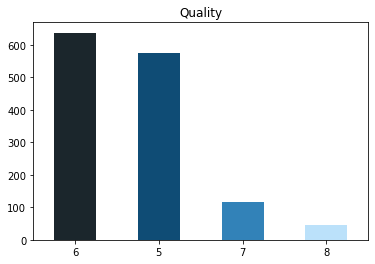

In [182]:
results = sub['quality'].value_counts()
results.plot.bar(color=['#1B262C', '#0F4C75', '#3282B8', '#BBE1FA'], rot=0)
plt.title("Quality")
plt.show()